#### Setup

In [67]:
import sys
print(sys.version)
print(sys.executable)

3.7.2 (default, Mar  4 2019, 17:13:23) 
[Clang 10.0.0 (clang-1000.10.44.4)]
/Users/Tom/.pyenv/versions/3.7.2/bin/python3.7


In [68]:
#import pdb; pdb.set_trace()

%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import re
import json
import psycopg2
from sqlalchemy.engine.url import URL

# connection to the database
# connection string for use in pandas:
con = str(URL(drivername='postgresql', 
              username=os.environ['DB_QIR_USERNAME'], 
              password=os.environ['DB_QIR_PASSWORD'], 
              host='localhost', 
              database='qir'))

# cursor for use with psycopg2
conn = psycopg2.connect(con)
cur = conn.cursor()  
print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


# Dataset demarcation by legal type and insolvency type
insolvencies can be of different types:
- Schuldsanering (R) = debt restructering
- Surseance (S) = suspension of payments
- Fallissement (F) = insolvency

and can involve a (person_legal_personality)
- rechtspersoon 
- natuurlijk persoon

For the thesis we are interested in companies in bankrupcty, the F/rechtspersoon combination. **51392** cases.  
For this purpose we created the insolvent view: **company_bankrupt_insolvents_view**

In [36]:
sql = """select left(case_number, 1) as insolvency_type, person_legal_personality from insolvents
         where insolvency_type in ('F', 'R', 'S');"""  # D is custom insolvent
df = pd.read_sql(sql, con)

pd.pivot_table(df, values='insolvency_type', 
                   index=['insolvency_type'],
                   columns=['person_legal_personality'], aggfunc=lambda x: len(x))


person_legal_personality,natuurlijk persoon,rechtspersoon
insolvency_type,,
F,18582,51392
R,98185,11
S,88,1817


## reasons for excluding bankruptcies of natural persons with a business

In [107]:
# faillissement natuurlijke personen, split zakelijk / prive
sql = """
select count(distinct i.id),  bn.id is not null as zakelijk
from insolvents i left join business_names bn on i.id = bn.insolvent_id
where person_legal_personality = 'natuurlijk persoon' and left(case_number, 1) = 'F'
group by zakelijk;
"""

pd.read_sql(sql, con)


,count,zakelijk
0,7142,False
1,11400,True


In [108]:
# hardly any reports associated with natural persons bankruptcies
sql = """
with cte_natural_person_bankruptcy as (select distinct i.id
                                       from insolvents i
                                              left join business_names bn on i.id = bn.insolvent_id
                                       where person_legal_personality = 'natuurlijk persoon'
                                         and left(case_number, 1) = 'F'
                                         and bn.id is not null)
select count(*)
from cte_natural_person_bankruptcy i join reports r on i.id = r.insolvent_id;
"""
pd.read_sql(sql, con)

,count
0,6


In [111]:
# multiple natural persons own one business, complicating matters
sql = """
select case_number, i.person_family_name, bn.name
from insolvents i join business_names bn on i.id = bn.insolvent_id
where i.id in (34481, 34483)
"""
pd.read_sql(sql, con)

,case_number,person_family_name,name
0,S.07/11/22,BREMER,BREMER SCHOEN- EN SLEUTELMAKERIJ
1,S.07/11/23,KNUIMAN e/v BREMER,BREMER SCHOEN- EN SLEUTELMAKERIJ


### natural persons in bankruptcy with reports are actually rechtspersonen

In [121]:
sql = """
with cte_natural_person_bankruptcy as (select distinct i.id, case_number
                                       from insolvents i
                                              left join business_names bn on i.id = bn.insolvent_id
                                       where person_legal_personality = 'natuurlijk persoon'
                                         and left(case_number, 1) = 'F'
                                         and bn.id is not null)
select i.case_number, r.identification
from cte_natural_person_bankruptcy i join reports r on i.id = r.insolvent_id;
"""
pd.read_sql(sql, con)

,case_number,identification
0,F.05/16/370,05_gel_16_370_F_V_01_B
1,F.05/16/370,05_gel_16_370_F_V_02
2,F.03/14/423,03_lim_14_423_F_V_02
3,F.03/14/423,03_lim_14_423_F_V_01_B
4,F.16/18/178,16_mne_18_178_F_V_01
5,F.16/15/371,16_mne_15_371_F_V_01


The following natural person bankruptcies are actually businesses:
- F.05/16/370 = Grip op Media Rijssen B.V.
- F.03/14/423 = Bemelmans-Jakobs Beheer B.V.
- F.16/18/178 = L. Janssens Ontwikkeling Advies en Beheer B.V.
- F.16/15/371 = Sushi Qube One B.V.

In [125]:
#  check if any BVs are found in natural person insolvents - note % escapes
sql = """
select count(*) 
from insolvents 
where person_legal_personality = 'natuurlijk persoon' 
   and person_family_name ilike '%%b.v%%';"""
pd.read_sql(sql, con)

,count
0,0


# Deduplication of insolvencies with two case numbers
There are a number of reasons found why insolvent companies can have more than one insolvency case number:
1. Due to a data error when the serial number is padded with a zero: e.g. F.01/16/0056
1. Due to the change of courts (Herinrichting Gerechtelijke Kaart) insolvencies were administered under another case number.
2. When a case is passed to another court it obtains a new case number.


Due to these reasons publications and reports of the same insolvency may be spread over different case numbers.
The system needs to re-associate the publications and reports to the new case number and leave a trace to the old case number.

The old case numbers without any publication or report can then be disregarded for the analysis.

In [53]:
# case 1: case padded zero
sql = """
select count(case_number) as padded_cnt
from insolvents
  where left(substring(case_number from '/(\d{1,4})$'), 1) = '0'
    and left(case_number, 1) = 'F' 
    and person_legal_personality = 'rechtspersoon';
"""
pd.read_sql(sql, con)

,padded_cnt
0,43


In [43]:
# case 2: case HGK migration.
# match case numbers using chamber of commerce or when missing the company name.
sql = """
select count(case_number) as migrated_cnt
from insolvents
  where substring(case_number from '^[D|F|S|R]\.\d{2}/\d{1,4}$') is not null
    and left(case_number, 1) = 'F' 
    and person_legal_personality = 'rechtspersoon';
"""
pd.read_sql(sql, con)

# two cases with typos in kvk that did not match earlier

,migrated_cnt
0,1010


In [95]:
# case 3: case transferred to another court
# new cases should have a insolvency start publication
sql = """select count(distinct case_number) as transferred_cnt
from company_bankrupt_insolvents_view i join publications p on i.id = p.insolvent_id 
where type_code = '1334'
       or (type_code = '1323' and (description like '%%overgedragen%%'
                                or description like '%%verdere publicaties worden verricht%%'));"""
pd.read_sql(sql, con)

,transferred_cnt
0,2691


In [72]:
# before dedup
sql = """select count(*) from company_bankrupt_insolvents_view;"""
print("number of cases before deduplication: %d" % pd.read_sql(sql, con).iloc[0,0])

# after dedup
sql = """select count(*) from company_bankrupt_deduped_insolvents_view;"""
print("number of cases after  deduplication: %d" % pd.read_sql(sql, con).iloc[0,0])

number of cases before deduplication: 51392
number of cases after  deduplication: 47608


# Process Mining of Insolvency Processes
Using process mining we like to get information on the flow of insolvency cases through the court system:

First we like to annotate the start and end date

Secondly we like to know the start and end status, e.g. how the insolvency started and ended

In further work we like to annotate intermediate states of interest


## Start year analysis using case number
The start year can be derived from the case number:
1. old format: F.**13**/123
2. new format: F.19/**13**/123

The year is 20**13** and can be extracted from the case number after determining the format in use.

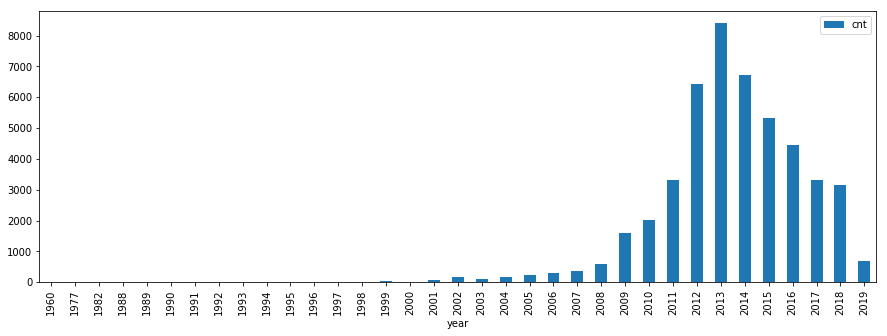

In [100]:
sql = """
with cte_year_start as (
    select substring(case_number from '[D|F|S|R]\.\d{2}/(\d{1,4})*') as year,
           count(*) as cnt
    from company_bankrupt_deduped_insolvents_view
    group by year
)    
select case when year::int > 50 then concat('19', year)  -- set breakpoint between 19 (now) and 60 (first observation)
       else concat('20', year) end as year,
       cnt
from cte_year_start
order by year;"""
df = pd.read_sql(sql, con).set_index("year")
df.plot.bar(figsize=(15, 5))

## set start and end date insolvency using publication.type_code
The exact start date can be derived from the following data: 

1. the court publication description and type code
2. the start date of the first administrator receiver
3. the start date of the first insolvent address

This field is derived from the publication type code. Certain type codes indicate the start of the insolvency, others the end. Example:

- 1100: uitspraak faillissement in hoger beroep op ...
- 1316: opheffing faillissement wegens gebrek aan baten op ...


## completeness start date
We measure the start date.  
Ideally it is 100%, there should always be one except in the case of legacy inflow:

1. inflow legacy: insolvency started before 01-01-2005 and not all publications in this case are within this register. 975 cases, ca. 2% is missing a start date publication.

There remain 356 cases without explainable missing start date, less than 1%


In [97]:
sql = """
select start_date_insolvency is not null as has_start_date, is_inflow_legacy, count(*) as cnt
from company_bankrupt_deduped_insolvents_view
group by 1, 2;"""
df = pd.read_sql(sql, con)
df['pct'] = df.cnt / df.cnt.sum() * 100
display(df)

,has_start_date,is_inflow_legacy,cnt,pct
0,False,False,356,0.747773
1,False,True,578,1.214082
2,True,False,46277,97.204251
3,True,True,397,0.833893


## case duration
case duration distribution for ended cases

In [ ]:
sql = """select start_dat
"""

## how do cases start out

In [114]:
# for cases with a start publication
sql = """
create temp table tmp_publication_types (type_code varchar, description  varchar);
insert into tmp_publication_types (type_code, description) values
  ('1100', 'uitspraak faillissement in hoger beroep'),
  ('1200', 'uitspraak faillissement in cassatie'),
  ('1300', 'uitspraak faillissement'),
  ('1301', 'uitspraak faillissement door tussentijdse beëindiging schuldsanering'),
  ('1302', 'uitspraak faillissement tijdens schuldsanering'),
  ('1303', 'uitspraak faillissement door ontbinding akkoord in schuldsanering '),
  ('1304', 'heropening faillissement door ontbinding akkoord in faillissement'),
  ('1305', 'uitspraak faillissement door ontbinding akkoord in surseance'),
  ('1306', 'uitspraak faillissement na beëindiging surseance '),
  ('3313', 'Beëindiging door omzetting in faillissement');

select pub.type_code, pt.description, count(*) as cnt
from company_bankrupt_deduped_insolvents_view ins
    join publications pub on ins.id = pub.insolvent_id
    join tmp_publication_types pt on pt.type_code = pub.type_code
group by 1, 2
order by cnt desc;
"""
df = pd.read_sql(sql, con)
df['pct'] = df.cnt / df.cnt.sum() * 100
df


,type_code,description,cnt,pct
0,1300,uitspraak faillissement,43664,93.388942
1,1306,uitspraak faillissement na beëindiging surseance,2941,6.290236
2,1100,uitspraak faillissement in hoger beroep,142,0.303711
3,1304,heropening faillissement door ontbinding akkoo...,6,0.012833
4,1301,uitspraak faillissement door tussentijdse beëi...,2,0.004278


#### Results
We can determine how cases start out. This can be sliced to a period, court, etc.<br>
Using a stacked area graph it can be shown how cases endings change over time.

F cases previously in S can also be identified using previous_case_number

## how do cases end

In [118]:
sql = """
create temp table tmp_publication_types (type_code varchar, description  varchar);
insert into tmp_publication_types (type_code, description) values
('1102', 'vernietiging faillissement in hoger beroep'),
('1202', 'vernietiging faillissement in cassatie'),
('1316', 'opheffing faillissement wegens gebrek aan baten'),
('1317', 'einde faillissement door verbindende uitdelingslijst'),
('1318', 'einde faillissement door goedkeuring akkoord'),
('1319', 'einde faillissement door verbindende uitdelingslijst na verzet'),
('1320', 'vernietiging faillissement na verzet'),
('1324', 'einde faillissement door voldoen van alle schulden'),
('1333', 'Faillissement omgezet in schuldsanering');


select pub.type_code, pt.description, count(*) as cnt
from company_bankrupt_deduped_insolvents_view ins
    join publications pub on ins.id = pub.insolvent_id
    join tmp_publication_types pt on pt.type_code = pub.type_code
group by 1, 2
order by cnt desc;
"""
df = pd.read_sql(sql, con)
df['pct'] = df.cnt / df.cnt.sum() * 100
df

,type_code,description,cnt,pct
0,1316,opheffing faillissement wegens gebrek aan baten,27239,75.904252
1,1317,einde faillissement door verbindende uitdeling...,7984,22.248231
2,1320,vernietiging faillissement na verzet,347,0.966951
3,1318,einde faillissement door goedkeuring akkoord,159,0.443070
4,1102,vernietiging faillissement in hoger beroep,92,0.256367
5,1319,einde faillissement door verbindende uitdeling...,46,0.128184
6,1333,Faillissement omgezet in schuldsanering,8,0.022293
7,1324,einde faillissement door voldoen van alle schu...,7,0.019506
8,1202,vernietiging faillissement in cassatie,4,0.011146


*like air the insolvencies ending contain a 20% good part and a 80% useless part*

## Intermediate states
Apart from beginning and end state many intermediate states can be identified from the data. One example is the moment of setting the verification meeting for which a timing constraint is set by the law.

### when are verification meetings set
Verfification meetings are supposed to be schedules (not held) within 14 days after the publication of bankruptcy. This demand is seen as a dead letter to be changed with the new law from 2019-1-1 onwards. From the distribution is can be seen that this deadline is almost never met, on the contrary, it appears breached up to a point that it needs further inspection.

In [120]:
sql = """
p.type_code in ('1309', '1310', '1325', '1326',
                              '2310', '2311', '2312', '2313', '2314', '2315', '2316', '2317', '2318',
                              '2338', '2339', '2340', '2341', '2342', '2343', '2344', '2345', '2346', '2347')
                                             
df = pd.read_sql(sql, con)

In [ ]:
df.days_after_start.plot.hist(bins=50);

In [ ]:
# see recent breaches
df[df.start_date_insolvency > datetime.date(2016, 1, 1)].plot.hist(bins=50)

# this data is right censored, cases which not yet had a verification meeting publication are not seen.

In [ ]:
# see recent breaches
import datetime
df[df.start_date_insolvency > datetime.date(2016, 1, 1)].sort_values(by=['days_after_start'], ascending=False).head(20)

In [ ]:
# pull a file e.g. the second
sql = """
select case_number, date, type_code, description, start_date_insolvency
from insolvents i join publications p on i.id = p.insolvent_id
where case_number = 'F.03/16/31'
order by date;
"""
pd.read_sql(sql, con).style

# Data Completeness Measures

- completeness of publications, insolvents and reports on CIR in dataset
- completeness of start date publications
- ? completeness of end date publications (for ended insolvencies)
- completeness of KvK number in company insolvents
- completeness of Administrator
- completeness of Judge

# Data Consistency Measueres
- insolvents should have at least one publication
- insolvents should have no more than one start date publication
- no orphans:
    - all reports are linked to one insolvent
    - all publications are linked to one insolvent
